# Import necessary libraries

In [69]:
# %pip install findspark
# %pip install pyspark

In [70]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, avg, max, min, year, month, concat_ws, when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Initialize Spark session

In [71]:

spark = SparkSession.builder \
    .appName("Sales Data Analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [72]:
# Load dataset into Spark DataFrame
data_path = "sales_data_sample.csv"
sales_df = spark.read.csv(data_path, header=True, inferSchema=True)

In [73]:
# Performance Optimization
spark.conf.set("spark.sql.shuffle.partitions", "100")

In [74]:
# Data cleansing
# Handle missing values (example: fill missing sales with 0)
sales_df = sales_df.fillna({"Sales": 0})

# Handle duplicates
sales_df = sales_df.dropDuplicates()

In [75]:
# Drop unnecessary columns
columns_to_drop = ["ORDERNUMBER","STATUS","PRODUCTCODE","ORDERDATE","PHONE", "ADDRESSLINE1", "ADDRESSLINE2", "POSTALCODE", "TERRITORY","CITY","STATE","COUNTRY"]
sales_df = sales_df.drop(*columns_to_drop)

In [76]:
sales_df.describe().show()

+-------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------+------------------+-----------------+---------------+----------------+--------+
|summary|  QUANTITYORDERED|        PRICEEACH|  ORDERLINENUMBER|             SALES|            QTR_ID|          MONTH_ID|           YEAR_ID| PRODUCTLINE|              MSRP|     CUSTOMERNAME|CONTACTLASTNAME|CONTACTFIRSTNAME|DEALSIZE|
+-------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------+------------------+-----------------+---------------+----------------+--------+
|  count|             2823|             2823|             2823|              2823|              2823|              2823|              2823|        2823|              2823|             2823|           2823|            2823|    2823|
|   mean|35.09280906836698|83.65854410201906|6.466170740347148|3553.8890

In [77]:
# Display the structure/schema of the DataFrame
sales_df.printSchema()
sales_df.cache()

root
 |-- QUANTITYORDERED: integer (nullable = true)
 |-- PRICEEACH: double (nullable = true)
 |-- ORDERLINENUMBER: integer (nullable = true)
 |-- SALES: double (nullable = false)
 |-- QTR_ID: integer (nullable = true)
 |-- MONTH_ID: integer (nullable = true)
 |-- YEAR_ID: integer (nullable = true)
 |-- PRODUCTLINE: string (nullable = true)
 |-- MSRP: integer (nullable = true)
 |-- CUSTOMERNAME: string (nullable = true)
 |-- CONTACTLASTNAME: string (nullable = true)
 |-- CONTACTFIRSTNAME: string (nullable = true)
 |-- DEALSIZE: string (nullable = true)



DataFrame[QUANTITYORDERED: int, PRICEEACH: double, ORDERLINENUMBER: int, SALES: double, QTR_ID: int, MONTH_ID: int, YEAR_ID: int, PRODUCTLINE: string, MSRP: int, CUSTOMERNAME: string, CONTACTLASTNAME: string, CONTACTFIRSTNAME: string, DEALSIZE: string]

In [78]:
# Total sales per product line
product_line_sales = sales_df.groupBy("PRODUCTLINE").agg(sum("SALES").alias("Total_Sales"))
product_line_sales.cache()
product_line_sales.show()

+----------------+------------------+
|     PRODUCTLINE|       Total_Sales|
+----------------+------------------+
|     Motorcycles| 1166388.339999999|
|    Vintage Cars|        1903150.84|
|Trucks and Buses|        1127789.84|
|    Classic Cars|3919615.6599999988|
|          Trains|         226243.47|
|           Ships| 714437.1300000001|
|          Planes| 975003.5699999998|
+----------------+------------------+



<ipython-input-79-33f1d9a9b643>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=product_line_sales_pd, x="PRODUCTLINE", y="Total_Sales", palette="coolwarm")


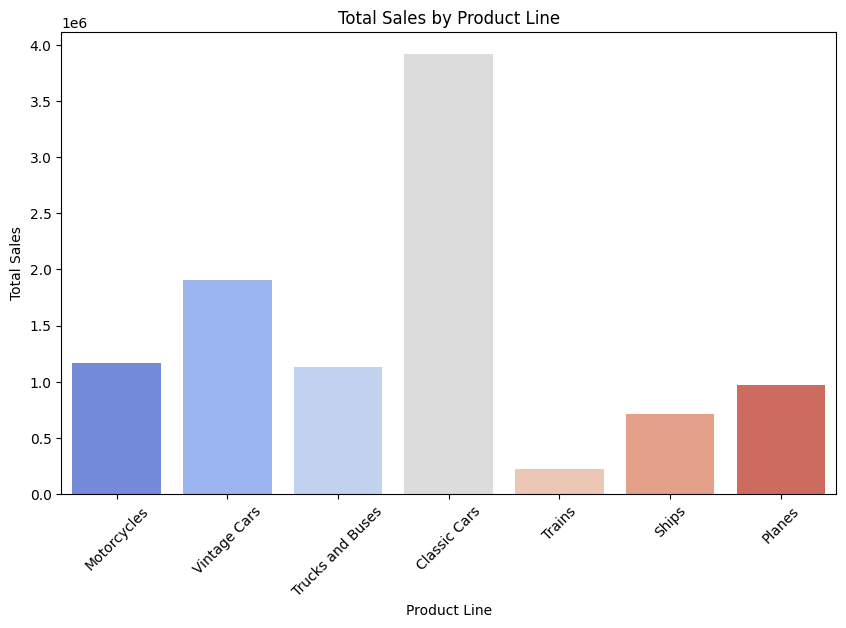

In [79]:
# Convert Spark DataFrame to Pandas for visualization
product_line_sales_pd = product_line_sales.toPandas()
# Visualization: Total sales by product line
plt.figure(figsize=(10, 6))
sns.barplot(data=product_line_sales_pd, x="PRODUCTLINE", y="Total_Sales", palette="coolwarm")
plt.title("Total Sales by Product Line")
plt.xlabel("Product Line")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.show()


In [80]:
# Combine CONTACTLASTNAME and CONTACTFIRSTNAME into FULLNAME
sales_df_fullname = sales_df.withColumn("FULLNAME", concat_ws(" ", col("CONTACTFIRSTNAME"), col("CONTACTLASTNAME")))
sales_df_fullname.cache()
# Group by FULLNAME and calculate total sales
full_name_sales = sales_df_fullname.groupBy("FULLNAME").agg(sum("SALES").alias("Total_Sales"))
full_name_sales.cache()
# Sort by total sales in descending order
sorted_sales = full_name_sales.orderBy(col("Total_Sales").desc())
sorted_sales.cache()
sorted_sales.show(10, truncate=False)

+-----------------+------------------+
|FULLNAME         |Total_Sales       |
+-----------------+------------------+
|Diego Freyre     |912294.11         |
|Valarie Nelson   |654858.0600000002 |
|Peter Ferguson   |200995.40999999997|
|Jeff Young       |197736.93999999994|
|Janine Labrune   |180124.90000000002|
|Eric Natividad   |172989.68000000008|
|Kwai Yu          |164069.44000000003|
|Sue Frick        |160010.27000000005|
|Victoria Ashworth|157807.80999999997|
|Anna O'Hara      |153996.13         |
+-----------------+------------------+
only showing top 10 rows



<ipython-input-81-63432d2264b2>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sorted_sales, x="FULLNAME", y="Total_Sales", palette="coolwarm")


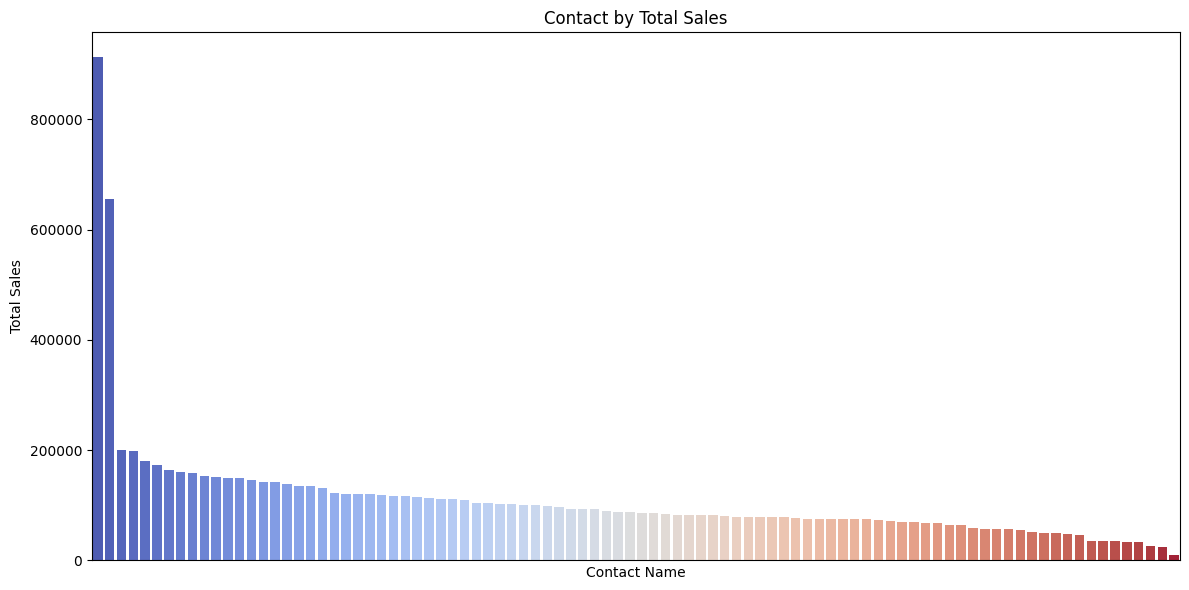

In [81]:
# Convert Spark DataFrame to Pandas for visualization
sorted_sales = sorted_sales.toPandas()

# Visualization: Total sales by customer
plt.figure(figsize=(12, 6))
sns.barplot(data=sorted_sales, x="FULLNAME", y="Total_Sales", palette="coolwarm")
plt.title("Contact by Total Sales")
plt.xlabel("Contact Name")
plt.ylabel("Total Sales")
plt.xticks(rotation=45, ha="right")  # Rotate and align the x-axis labels
plt.xticks([], [])
plt.tight_layout()  # Adjust layout for better spacing
plt.show()
sorted_sales = spark.createDataFrame(sorted_sales)


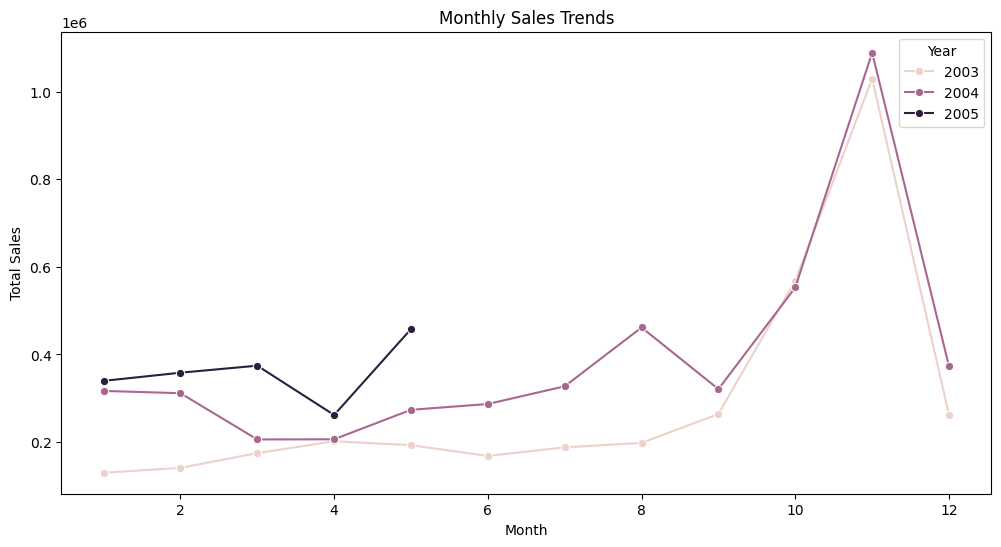

In [82]:
# Monthly Sales Trends
monthly_sales = sales_df.groupBy("YEAR_ID", "MONTH_ID").agg(sum("SALES").alias("Monthly_Sales"))
monthly_sales.cache()
monthly_sales_pd = monthly_sales.orderBy("YEAR_ID", "MONTH_ID").toPandas()


plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales_pd, x="MONTH_ID", y="Monthly_Sales", hue="YEAR_ID", marker="o")
plt.title("Monthly Sales Trends")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.legend(title="Year")
plt.show()


In [83]:
# Feature Engineering: Create a new column for profit margin (example)
# Assuming MSRP is Manufacturer Suggested Retail Price
sales_df_profit = sales_df.withColumn("ProfitMargin", col("MSRP") - col("PRICEEACH"))
sales_df_profit.cache()
sales_df_profit.select("PRODUCTLINE", "ProfitMargin").show(5)


+----------------+------------+
|     PRODUCTLINE|ProfitMargin|
+----------------+------------+
|    Vintage Cars|         1.0|
|    Vintage Cars|       -35.0|
|    Classic Cars|        47.0|
|Trucks and Buses|        36.0|
|    Classic Cars|        17.0|
+----------------+------------+
only showing top 5 rows



<ipython-input-84-968c5ab543c8>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_customers_pd, x="Total_Sales", y="CUSTOMERNAME", palette="viridis")


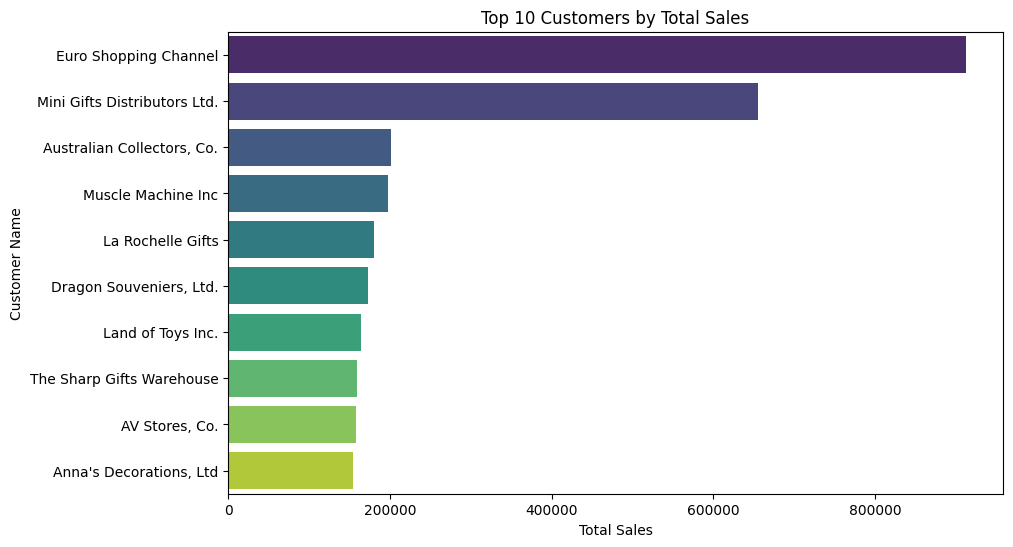

In [84]:
#Top Customers by Total Sales
customer_sales = sales_df.groupBy("CUSTOMERNAME").agg(sum("SALES").alias("Total_Sales"))
customer_sales.cache()
top_customers = customer_sales.orderBy(col("Total_Sales").desc()).limit(10)
top_customers.cache()
top_customers_pd = top_customers.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=top_customers_pd, x="Total_Sales", y="CUSTOMERNAME", palette="viridis")
plt.title("Top 10 Customers by Total Sales")
plt.xlabel("Total Sales")
plt.ylabel("Customer Name")
plt.show()

In [86]:
# Advanced Analytics - Predictive Modeling
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.regression import LinearRegression
# Convert categorical columns to numerical using StringIndexer
productline_indexer = StringIndexer(inputCol="PRODUCTLINE", outputCol="PRODUCTLINE_INDEX")
dealsize_indexer = StringIndexer(inputCol="DEALSIZE", outputCol="DEALSIZE_INDEX")

sales_df = productline_indexer.fit(sales_df).transform(sales_df)
sales_df = dealsize_indexer.fit(sales_df).transform(sales_df)

assembler = VectorAssembler(inputCols=["QUANTITYORDERED", "PRICEEACH","PRODUCTLINE_INDEX","DEALSIZE_INDEX"], outputCol="features")
feature_df = assembler.transform(sales_df)
# Split data into training and testing sets
train_data, test_data = feature_df.randomSplit([0.8, 0.2], seed=42)

In [90]:
# Initialize and train the Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="SALES")
lr_model = lr.fit(train_data)

In [91]:
# Model evaluation on test set
predictions = lr_model.transform(test_data)
evaluator = RegressionEvaluator(labelCol="SALES", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="SALES", predictionCol="prediction", metricName="r2")
rmse = evaluator.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE) on Test Data: {rmse}")
print(f"R-squared (R²) on Test Data: {r2}")

Root Mean Squared Error (RMSE) on Test Data: 898.8905884659131
R-squared (R²) on Test Data: 0.7836792962759639


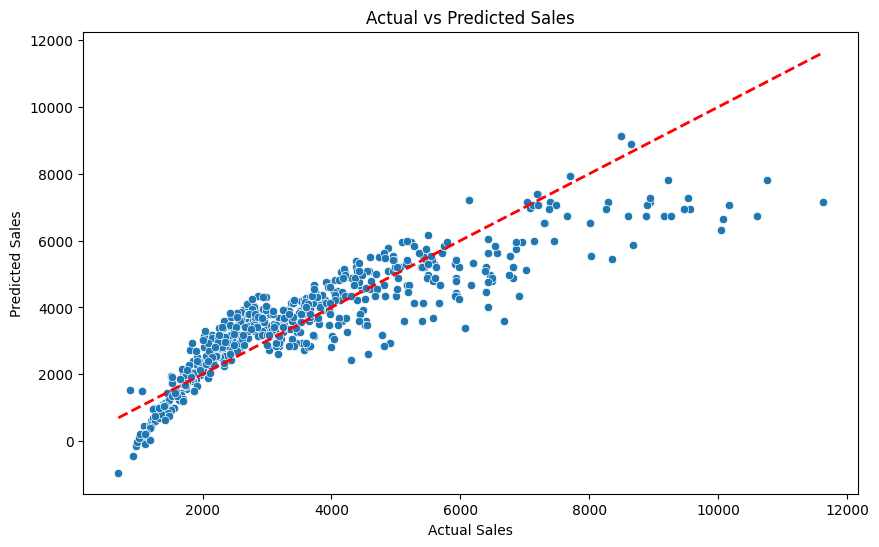

In [92]:
# Visualization of Predictions vs Actual Values
predictions_pd = predictions.select("prediction", "SALES").toPandas()
plt.figure(figsize=(10, 6))
sns.scatterplot(x="SALES", y="prediction", data=predictions_pd)
plt.plot([predictions_pd["SALES"].min(), predictions_pd["SALES"].max()],
         [predictions_pd["SALES"].min(), predictions_pd["SALES"].max()],
         color='red', linestyle='--', linewidth=2)
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual vs Predicted Sales")
plt.show()


In [ ]:
# # Stop Spark session
spark.stop()